<a href="https://colab.research.google.com/github/Jay9711/Deeplearning-neuralnetwork/blob/master/Assignement__(v1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Emotion Expressions classification using CNN Pytorch**

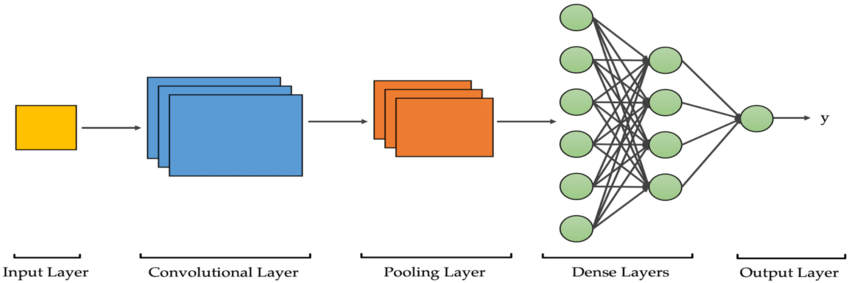

The primary job given to us was Pytorch, therefore we utilized it. In order to comprehend and design Image classifier, the nn library performed remarkable duties throughout the construction of the CNN network.


### LOADING THE LIBRARIES AND THE DATASET.

In [ ]:
# conda install torchvision -c pytorch

You can use the above line to add torchvision library in conda - jupyter notebook . 

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch.optim import Adam
from torch.optim import optimizer
from torch.autograd import Variable

Since, the dataset is too big it is difficult the run the with cpu it has around 28000 training images and 7000 validation images so on cpu it will take much more time and if we use cuda it will be a little be faster so just make sure to check if cuda is available. 

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

make sure to add the the whole folder to the google drive and then mount the drive so that google colab can directly upload from the drive. i have added this section from the mnist tutorial by TA. 

In [ ]:
train_dataset_path = './train'
val_dataset_path = './validation'

Contribution : so we used (https://towardsdatascience.com/pytorch-vision-multiclass-image-classification-531025193aa) and (https://www.youtube.com/watch?v=ovZ_54IUSU4) to firstly understand what does Transforms do and we did changed the hyperparameters to improve our accuracy. 

1) To resize, we will be using the resize() image, because all the images can be of different sizes, and to standardize the images, its better to have them in one size. we saw different sizes like 224, 96 , and finally 64 is the perfect zoom in size which gives the best accuracy.

2). we also started with .5.5.5 as the mean and .5.5.5 as the stddev there is a way to calulate the mean and std dev but i tried and tested and found that removing the normalization helps in better determining the image. but i think in RGB color images it can help better. you can consider x as pixels below and count. 


> mean = sum(x)/length(x)

> variance = sum((x - mean(x)). ^2)/(length(x) - 1);


3). After seeing the validation data i determined that we need to do random rotation and random horizontal flips as well so that the model can train on different datasets and better predict it.



In [ ]:

train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(.1),
    transforms.ToTensor(),
])
val_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()

])

In this section we Import the data using the ImageFolder library from Torchvision. we learned imagefolder using the following link (https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/)

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, 
                            transform = train_transforms) 
val_dataset = torchvision.datasets.ImageFolder(root = val_dataset_path, 
                            transform = val_transforms) 


In [ ]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle = True,
                                          num_workers=1  
)
valloader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=32,
                                          shuffle = False,
                                          num_workers=1  
)
valloader

Now we import the data using dataloader set and then we use numpy and matplotlib to see sample images from the data. here we can see some images are tiled and how rotation has happend in some images. 

Labels:  tensor([4, 0, 5, 4, 0, 3, 3, 0, 0, 0, 3, 5, 3, 3, 2, 5, 5, 2, 3, 6, 3, 1, 0, 0,
        6, 3, 3, 4, 3, 4, 4, 3, 4, 0, 2, 4, 4, 2, 5, 4, 5, 3, 0, 4, 1, 2, 5, 0,
        6, 3, 3, 4, 3, 3, 3, 2, 5, 6, 0, 3, 0, 2, 2, 5])


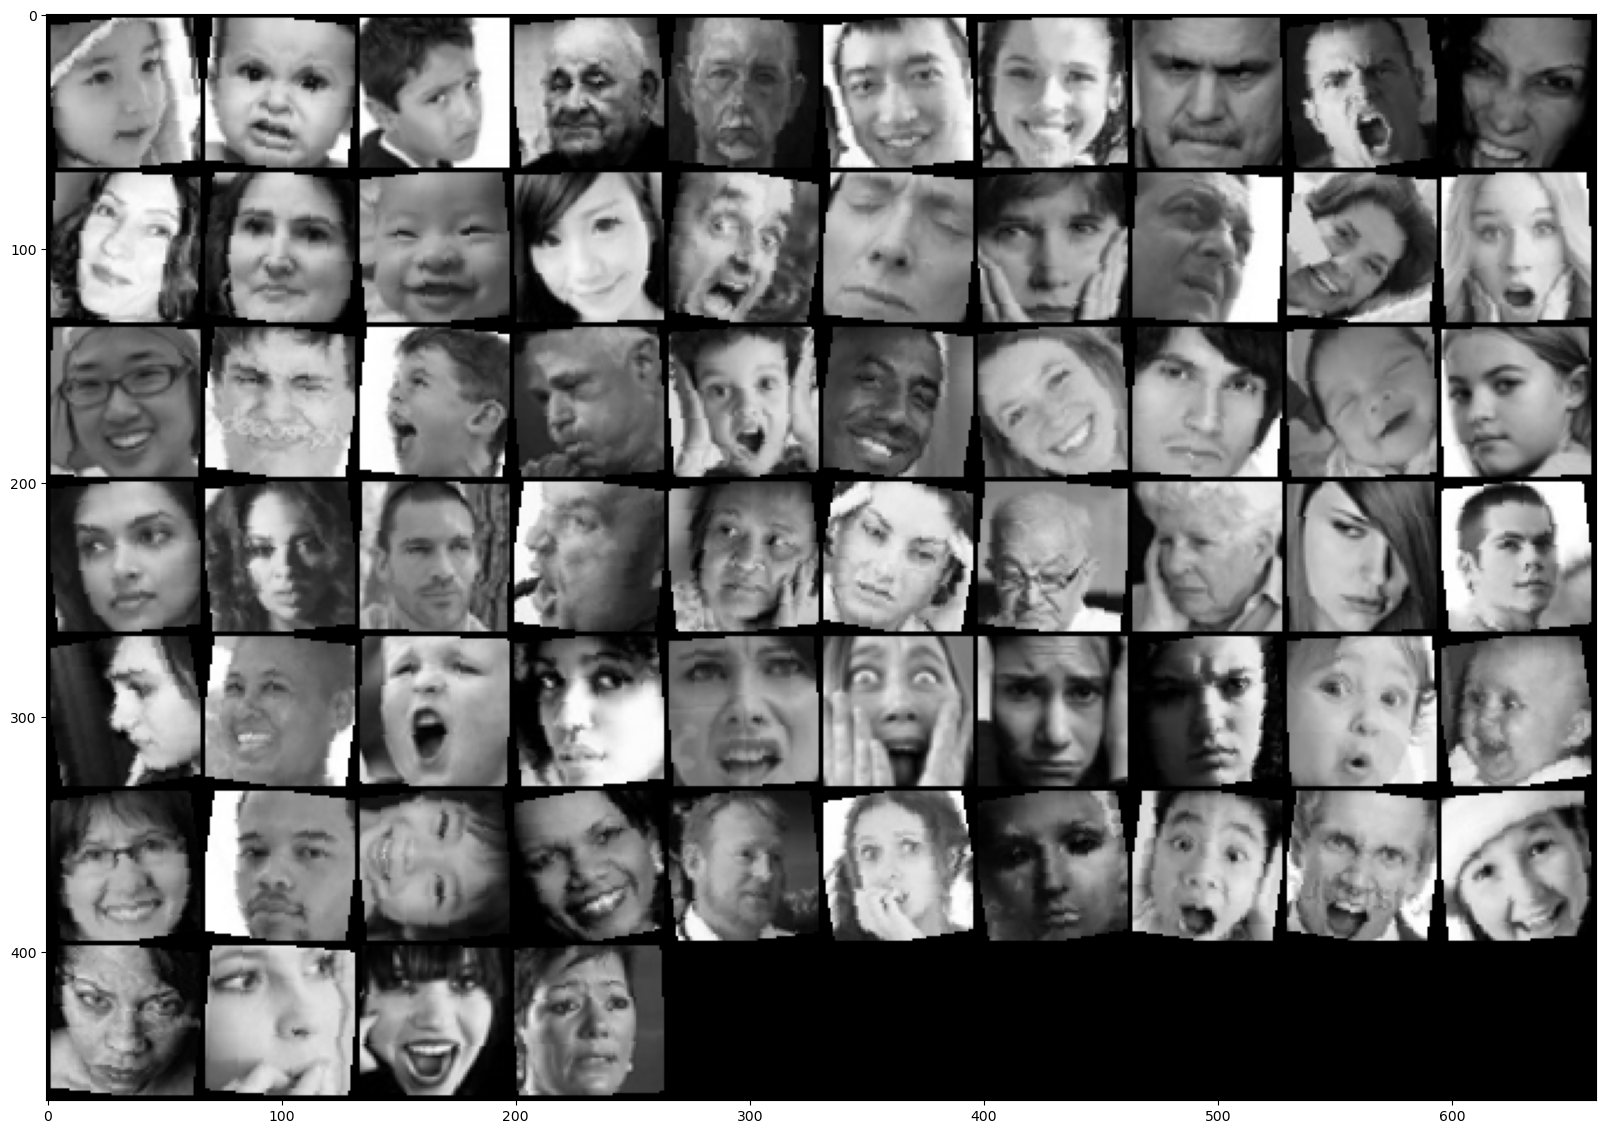

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

batch= next(iter(trainloader))
images,labels = batch
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(grid,(1,2,0)))
print('Labels: ',labels)

we have used (https://www.youtube.com/watch?v=ovZ_54IUSU4) this link in learning how to import the folder and plot it on a graph

now we need to know how many classes are there and basis of that we can create a model which classifies in one of therse classes to see the classes from the dataset we also need this information to train the model.

In [ ]:
idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}
idx2class


{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

we used this link to get the name of classification folder (https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a)
we store the data from the idx2class into a variable called classes. we will use this later to determine 

In [ ]:
classes = []
for i in idx2class.values():
    classes.append(i)
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


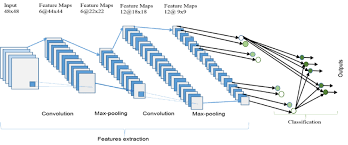


A CNN is a neural network which consist of a nueral layer . a convolutional layer, a pooling layer and a fully connected (FC) layer.

Convolution involves a kernel or filter inside this layer travelling through the image's receptive fields, checking for the presence of a feature.

The kernel sweeps across the whole picture over numerous rounds. A dot product is computed between the input pixels and the filter after each cycle. A feature map or convolved feature is the end result of the series of dots. Finally, in this layer, the picture is turned into numerical values, allowing the CNN to understand the image and extract meaningful patterns from it.

The pooling layer is also very important cause this layer reduces the number of parameters in the layer and improves the efficiency of the model.

The FC layer in the CNN is where picture categorization occurs based on the characteristics extracted in the preceding layers. Fully connected in this context indicates that all of the inputs or nodes from one layer are linked to every activation unit or node in the following layer.

we have made a complex model with 3 Convolutional layer, 3 relu activation layer, 1 pooling layer , 2 batch normalization layer and a fully connected layer. 

so in this model we start from 3 input channels which are then converted in 12 channels then we normalize those 12 ouputted features. 

Again the process runs for convulational layer but before that the pooling layer comes in which reduces the complexity and image size to the kernal size. 

and then we have one more complete layer of convulational layer after which we normalize it with the bathcnormalization and after going to the activation function it goes to the fully connected layer which finally determines and from 36 outputs it comes down to 7 outputs or 7 categories.

This is how our Forwarding layer works.



In [ ]:
from numpy.ma.core import outerproduct
#CNN NETWORK

class ConvNet(nn.Module):
    def __init__(self,num_classes = len(classes)):
        super(ConvNet,self).__init__()

        #Input (64,3,64,64)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3, stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        #shape(64,12,64,64)
        self.relu1= nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2)
        #shape(64,12,32,32)
        self.conv3 = nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3, stride=1,padding=1)
        self.relu3= nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3, stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        #shape(64,12,32,32)
        self.relu2= nn.ReLU()
        self.fc = nn.Linear(in_features=32*32*32,out_features=num_classes)

    def forward(self,input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)

        output = self.pool(output)
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        
        output = output.view(-1,32*32*32)

        output = self.fc(output)

        return output

In [ ]:
model = ConvNet(num_classes=len(classes)).to(device)

Here We initialize the model.

After initializing the model we use the Adam Model for optimization . The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

The results of the Adam optimizer are generally better than every other optimization algorithm, have faster computation time, and require fewer parameters for tuning.


CROSS ENTROPY LOSS : The understanding of Cross-Entropy is pegged on understanding of Softmax activation function.

Consider a 4-class classification task where an image is classified as either a dog, cat, horse or cheetah.

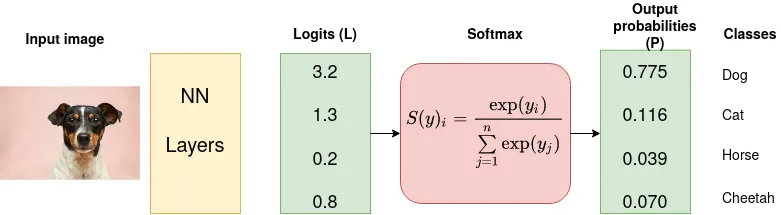

In the above Figure, Softmax converts logits into probabilities. The purpose of the Cross-Entropy is to take the output probabilities (P) and measure the distance from the truth values.

The objective is to make the model output be as close as possible to the desired output (truth values). During model training, the model weights are iteratively adjusted accordingly with the aim of minimizing the Cross-Entropy loss. The process of adjusting the weights is what defines model training and as the model keeps training and the loss is getting minimized, we say that the model is learning.

In [ ]:
optimizer=Adam(model.parameters(),lr=.001,weight_decay=.0001)
loss_function = nn.CrossEntropyLoss()

In [ ]:
train_count = len(train_dataset)
val_count = len(val_dataset)

now in this section we execute our model to train and after every epoch the model is showing %done meaning the training data accuracy and then it checks for testing data accuracy in the same epoch. 

Contribution. I have tested the model everytime so that we can see which epoch it gives the best testing accuracy and does not overfit training. 

In [ ]:
from torch.cuda import is_available
best_accuracy = 0.0
for epoch in range(50):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    for i,(images,labels) in enumerate(trainloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
    
        optimizer.zero_grad()

        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()

        train_loss+=loss.cpu().data*images.size(0)
        _,prediction = torch.max(outputs.data,1)

        train_accuracy +=int(torch.sum(prediction==labels.data))


    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count
    print(f'% Done {(train_accuracy*100)}')
  #eval on testing dataset
    model.eval()
    test_accuracy=0.0
    for i, (images,labels) in enumerate(valloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    val_accuracy=test_accuracy/val_count
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(val_accuracy))
    if val_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=val_accuracy
    print(f'Best_accuracy = {best_accuracy}')

% Done 35.83845112938482
Epoch: 0 Train Loss: tensor(1.7812) Train Accuracy: 0.35838451129384824 Test Accuracy: 0.4193320124540051
Best_accuracy = 0.4193320124540051
% Done 43.856909892092574
Epoch: 1 Train Loss: tensor(1.4618) Train Accuracy: 0.4385690989209257 Test Accuracy: 0.46702519105575996
Best_accuracy = 0.46702519105575996
% Done 47.371708129488916
Epoch: 2 Train Loss: tensor(1.3837) Train Accuracy: 0.47371708129488915 Test Accuracy: 0.4385791112369091
Best_accuracy = 0.46702519105575996
% Done 49.762326081676555
Epoch: 3 Train Loss: tensor(1.3232) Train Accuracy: 0.49762326081676556 Test Accuracy: 0.48075290121709596
Best_accuracy = 0.48075290121709596
% Done 51.72617188855349
Epoch: 4 Train Loss: tensor(1.2727) Train Accuracy: 0.5172617188855348 Test Accuracy: 0.51783187093122
Best_accuracy = 0.51783187093122
% Done 53.228548627736714
Epoch: 5 Train Loss: tensor(1.2343) Train Accuracy: 0.5322854862773672 Test Accuracy: 0.5065100481177469
Best_accuracy = 0.51783187093122
% Do

So, during the 37 epocs we gained 71 % accuracy in training dataset. 

we had an average of 52% accuracy overall in the model. 

but the maximum accuracy that we reached is 55% is on the 13th epoch when the model was 60% trained. so we can see after that a little overfitting has been done but as the dataset is too large it is not overfitted anymore.

# **Difficulties Faced**.

I faced many difficulties during the project the first was learning pytorch. The second was understanding how CNN networks work in pytorch but youtube tutorials helped a lot also the python tutrial sent by our TA was helpful alot. 

The first issue that i faced is that the dataset is too big it is aroung 35000 images and can take around 7 hrs to run 50 epochs or so. so what i did was that in the main function i implement 2 varialbes called temp and temp 2 i set the temp 2 to 100 and incremented temp1 after each iteration so when 100*64 = 6400 images were trained i use to go to the next epoch and based on those answers i improved my hyperparameters.

This helps in one thing the time reduced for epochs is way less and we can make an estimation of the original model. 

Another difficulty that i faced is was that during different phases of hyperparameters i could not increase the accuracy i started with 47% and tried different permutations and combination of hyperparameters and finally took it to 55% accurate model.


# **REFERENCES:**



> My code was mainly referenced from ( https://www.youtube.com/watch?v=9OHlgDjaE2I ) and ( https://github.com/gaurav67890/Pytorch_Tutorials/blob/master/cnn-scratch-training.ipynb )



> https://www.youtube.com/watch?v=bA95Olv_eY0

> https://discuss.pytorch.org/t/how-can-i-know-the-size-of-data-loader-when-i-use-torchvision-datasets-imagefolder/7800/4

> https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

> https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a

> https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

> https://www.youtube.com/watch?v=ovZ_54IUSU4

> https://discuss.pytorch.org/t/how-to-sample-images-belonging-to-particular-classes/43776/3

> https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

> https://towardsdatascience.com/pytorch-vision-multiclass-image-classification-531025193aa

> Ihttps://www.kaggle.com/code/anand1994sp/facial-expression

> https://discuss.pytorch.org/t/reducing-the-size-of-pytorch-datasets-created-with-iamgefolder-in-a-balanced-fashion/142994


> https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7

> https://www.techtarget.com/searchenterpriseai/definition/convolutional-neural-network#:~:text=How%20convolutional%20neural%20networks%20work,more%20detailed%20after%20each%20layer.

> https://github.com/Rutvij1998/Image-Classifier-using-Tensorflow-and-PyTorch/blob/main/Flower_Classifier.ipynb

> https://www.google.com/search?q=how+to+calculate+the+mean+and+standard+deviation+of+an+image&oq=how+to+calculate+the+mean+and+standard+deviation+of+an+image&aqs=chrome..69i57j33i160l3j33i299l2.12728j0j7&sourceid=chrome&ie=UTF-8

> https://www.researchgate.net/figure/The-overall-architecture-of-the-Convolutional-Neural-Network-CNN-includes-an-input_fig4_331540139

> https://www.google.com/search?q=why+do+we+use+adam+optimizer&oq=why+do+we+use+adam+&aqs=chrome.1.69i57j0i512j0i22i30l6j0i390i650l2.5651j0j7&sourceid=chrome&ie=UTF-8

> https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e



































